In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import scipy
from IPython.display import Video
from tqdm import tqdm
# from sklearn import neural_network, metrics, gaussian_process, preprocessing, svm, neighbors
# from sklearn import pipeline, model_selection

# from keras import metrics
# from keras import backend as K
from scipy.stats import pearsonr
from sklearn import svm, linear_model
# import microscPSF.microscPSF as msPSF

from scipy import matrix
from scipy.sparse import coo_matrix
import time
from scipy import linalg
from skimage import color, data, restoration
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import convolve2d as conv2
# import matlab.engine

# from sklearn.preprocessing import Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.experimental import enable_iterative_imputer
from scipy import signal
from sklearn.impute import SimpleImputer

import os
from IPython.lib.display import YouTubeVideo


# Image formation

Define constants: psf height width and image rescaling factor

In [2]:
psf_w,psf_h,scale = 512,512,8 # Define constants: psf height width and image rescaling factor
psf_window_w, psf_window_h = round(psf_w/scale), round(psf_h/scale)

Define approximate PSF function 

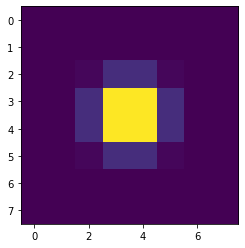

In [3]:
def psf_guass(w=psf_w, h=psf_h, sigma=3):
    # blank_psf = np.zeros((w,h))
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    xx, yy = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    psf = gaussian(xx, 0, sigma) * gaussian(yy, 0, sigma)
    return  psf/psf.sum() # Normalise PSF "energy"

static_psf = psf_guass(w=round(psf_window_h/scale), h=round(psf_window_w/scale), sigma=1 / 5); plt.imshow(static_psf) 

In [4]:
Video("eiffel_smlm.mp4") # Credit: Ricardo Henriques

# Deconvolution

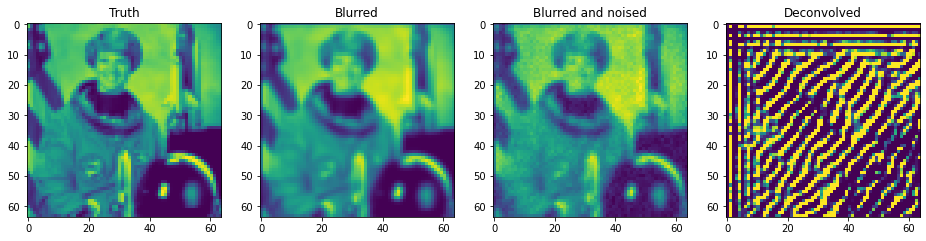

In [5]:
astro = rescale(color.rgb2gray(data.astronaut()), 1.0 / scale)
astro_blur = conv2(astro, static_psf, 'same') # Blur image
astro_corrupt = astro_noisy = astro_blur + (np.random.poisson(lam=25, size=astro_blur.shape) - 10) / 255. # Add Noise to Image
deconvolved_RL = restoration.richardson_lucy(astro_corrupt, static_psf, iterations=30)  # RL deconvolution

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(16,7))
ax[0].imshow(astro);ax[0].set_title('Truth')
ax[1].imshow(astro_blur);ax[1].set_title('Blurred')
ax[2].imshow(astro_noisy);ax[2].set_title('Blurred and noised')
ax[3].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max());ax[3].set_title('Deconvolved');

# Richardson Lucy Deconvolution

We can achieve a model for image formation of an ideal system by generating a measurement matrix $\mathbf{H}$ that acts on the structure $\mathbf{g}$ we are trying to find (assuming the structure is quantised) to produce a pixelated image $\mathbf{f}$ (n-dimensional):

<!-- %%latex -->
\begin{align*}
\underbrace{\mathbf{f}}_\text{Image} &= \overbrace{\mathbf{H}}^\text{Measurement matrix} \underbrace{\mathbf{g}}_\text{Object}\\
\end{align*}

In summation form:

\begin{align*}
f_{N_p}&=\sum_{N_v} H_{N_p, N_v} g_{N_v}\\
 \overbrace{
\begin{bmatrix} 
    f_{11} \\
    \vdots  \\
    f_{N_p}
    \end{bmatrix}
}^{N_p \times 1} \quad &= \overbrace{
\begin{bmatrix} 
    H_{11} & H_{12} & \dots \\
    \vdots & \ddots & \\
    H_{N_v1} &        & H_{N_v N_p} 
    \end{bmatrix}
}^{N_p \times N_v}  \overbrace{
\begin{bmatrix} 
    g_{11} \\
    \vdots  \\
    g_{N_v}
    \end{bmatrix}
}^{N_v \times 1}\\
\end{align*}

In [6]:
N_v = np.ma.size(astro);N_v
N_p = np.ma.size(astro_blur);N_p
measurement_matrix = matrix(np.zeros((N_p, N_v)))

However, the system will be corrupted by noise such that:

\begin{align*}
\mathbf{f}= \mathbf{H} (\mathbf{g}+\mathbf{b})\\
\end{align*}

Assuming $\mathbf{b}$ as being a Poissonian noise distribution we can begin solve the inverse problem of finding $\mathbf{g}$ using maximum liklihood:

\begin{align*}
\operatorname{Pr}(\widehat{\mathbf{f}} | \mathbf{g}, \mathbf{b}) &=\prod_{i}\left(\frac{(H \mathbf{g}+\mathbf{b})_{i}{\widehat{\mathbf{f}}_{i}} \exp \left(-(H \mathbf{g}+\mathbf{b})_{i}\right)}{\widehat{\mathbf{f}}_{i} !}\right)
\end{align*}

It is then possible to solve for $\mathbf{g}$ iteratively giving the iterative Richardson lucy deconvolution algorithm in matrix form:

\begin{align*}
\mathbf{g}^{(k+1)}&=\operatorname{diag}\left(H^{T} \mathbf{1}\right)^{-1} \operatorname{diag}\left(H^{T} \operatorname{diag}\left(H \mathbf{g}^{(k)}+\mathbf{b}\right)^{-1} \mathbf{f}\right) \mathbf{g}^{(k)}
\end{align*}

In convolution notation with a spatially invariant point spread function (P, where P* is the flipped PSF) this can be compressed to:

<!-- %%latex -->
\begin{align*}
\hat{g}^{(t+1)} & =\hat{g}^{(t)} \cdot\left(\frac{f}{\hat{g}^{(t)} \otimes P} \otimes P^{*}\right)
\end{align*}

So, if we know $\mathbf{H}$ and be extension $P$ we can deconvolve any image to retrieve a good approximation of an imaged object

# Knowing $\mathbf{H}$

Knowing $P$ is straightforward either experimentally or theoretically:

For simple optical systems the Point Spread Function can be derived i.e for a perfect lens in a microscope with a glass slide and a liquid interface there is a closed form expression for each of the field components:
\begin{align*}
\begin{array}{l}
h(x, y, z)=\left|I_{0}\right|^{2}+2\left|I_{1}\right|^{2}+\left|I_{2}\right|^{2} \\
I_{0}(x, y, z)=\int_{0}^{\alpha} B_{0}(\theta, x, y, z)\left(t_{s}^{(1)} t_{s}^{(2)}+t_{p}^{(1)} t_{p}^{(2)} \frac{1}{n_{s}} \sqrt{n_{s}^{2}-n_{i}^{2} \sin ^{2} \theta}\right) d \theta \\
I_{1}(x, y, z)=\int_{0}^{\alpha} B_{1}(\theta, x, y, z)\left(t_{p}^{(1)} t_{p}^{(2)} \frac{n_{i}}{n_{s}} \sin \theta\right) d \theta \\
I_{2}(x, y, z)=\int_{0}^{\alpha} B_{2}(\theta, x, y, z)\left(t_{s}^{(1)} t_{s}^{(2)}+t_{p}^{(1)} t_{p}^{(2)} \frac{1}{n_{s}} \sqrt{n_{s}^{2}-n_{i}^{2} \sin ^{2} \theta}\right) d \theta \\
B_{m}(\theta, x, y, z)=\sqrt{\cos \theta} \sin \theta J_{m}\left(k \sqrt{x^{2}+y^{2}} n_{i} \sin \theta\right) e^{j W(\theta)} \\
W(\theta)=k\left\{t_{s} \sqrt{n_{s}^{2}-n_{i}^{2} \sin ^{2} \theta}+t_{i} \sqrt{n_{i}^{2}-n_{i}^{2} \sin ^{2} \theta}-t_{i}^{*} \sqrt{n_{i}^{* 2}-n_{i}^{2} \sin ^{2} \theta_{t}}\right. \\
\left.+t_{g} \sqrt{n_{g}^{2}-n_{i}^{2} \sin ^{2} \theta}-t_{g}^{*} \sqrt{n_{g}^{* 2}-n_{i}^{2} \sin ^{2} \theta}\right\}
\end{array}
\end{align*}

Knowing $P$ experimentally is relies on capturing images of bright objects that are smaller than the resolution of the instrument.

We then **align and average** these multiple samplings of the PSF to approximate $P$

However, $P$ is known to vary through lens imperfections causing optical abberations, meaning $\mathbf{H}$ is once again useful.

$\mathbf{H}$ can also be written in terms of points spread functions:
\begin{align*}
\begin{bmatrix} 
    f_{1} \\
    \vdots  \\
    f_{N_p}
    \end{bmatrix} \quad =
\begin{bmatrix} 
    P_{1} \\
    \vdots \\
    P_{N_v}
    \end{bmatrix}    
\begin{bmatrix} 
    g_{1} \\
    \vdots  \\
    g_{N_v}
    \end{bmatrix}
\\
\end{align*}

Where $P_n$ is a serialised Point Spread Function at the $n^\text{th}$ serialed pixel poisition. It's also possible to do this with tensors, but serialising is as functional



Now, the difficulty therin lies that we do not know $P_n$ at every $n$; experimentally we know P_n at *most* positions but some form of **interpolation** is needed.

It's fair to assume that the PSF varies smoothly for all $P_n$, but, there are several fringe cases of imaging system where this assumption falls flat and so interpolation alone would not produce a completely general deconvolution algorithm.

<p float="center">
    <img src="moire.png" width="200"/>
    <img src="lightfield.png" width="200"/>
</p>

- **Structured illumination microscopy (SIM)** uses sinusoidally patterned light to increase image resolution
- **Lightfield microscopy** uses an array of microlenes to record a 3D image on a 2D camera

Both have funky spatially varying point spread functions.

# Building $\mathbf{H}$ from simulation

Define a function that scales the PSF as a function of radial distance

In [7]:
def sigma_scale(r_dist):
    return (r_dist + 0.1) * 1

Set up arrays for generating H

In [8]:
zero_image = np.zeros_like(astro)

x_astro, y_astro = astro_blur.shape
xx_astro, yy_astro = np.meshgrid(np.linspace(-1, 1, x_astro),
                                    np.linspace(-1, 1, y_astro))

Store sinusoidal illumination incase things go well:

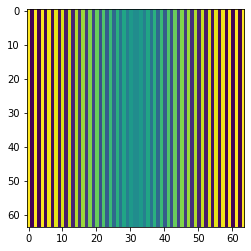

In [9]:
illumination = np.cos(64 / 2 * np.pi * xx_astro)
plt.imshow(illumination)

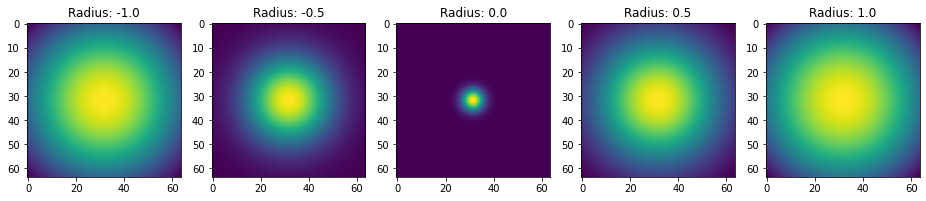

In [10]:
r_map = np.sqrt(xx_astro**2 + yy_astro**2)
radius_samples = np.linspace(-1,1,5)
fig,ax = plt.subplots(nrows=1,ncols=len(radius_samples),figsize=(16,7))
for i,radius in enumerate(np.linspace(-1,1,5)):
    psf_current = psf_guass(w=psf_window_w,
                        h=psf_window_h,
                        sigma=sigma_scale(radius))
    ax[i].imshow(psf_current);ax[i].set_title("Radius: " + str(radius))
plt.show()

100%|██████████| 4096/4096 [21:20<00:00,  3.20it/s]


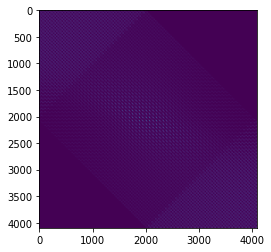

In [11]:
psf_window_volume = np.full((N_v,psf_window_w, psf_window_h), np.NaN)

for i in tqdm(np.arange(N_v)):
    coords = np.unravel_index(i, astro.shape)
    r_dist = r_map[coords]
    sigma = sigma_scale(r_map[coords])
    psf_current = psf_guass(w=psf_window_w,
                            h=psf_window_h,
                            sigma=sigma * illumination[coords])
    psf_current = psf_guass(w=psf_window_w,
                            h=psf_window_h,
                            sigma=sigma)
    psf_window_volume[i, :, :] = psf_current
    delta_image = np.zeros_like(astro)
    delta_image[np.unravel_index(i, astro.shape)] = 1
    delta_PSF = scipy.ndimage.convolve(delta_image, psf_current)
    measurement_matrix[i, :] = delta_PSF.flatten()
    # plt.imshow(psf_current)
    # plt.imsave(f'./output/psfs/{str(i).zfill(6)}.png',psf_window_volume[:,:,i])
#     plt.show()
# pd.DataFrame(measurement_matrix)
astro_noisy_vector = np.matrix(astro_noisy.flatten()).transpose()
plt.imshow(measurement_matrix)

In [13]:
from numba import jit, prange

# psf_window_volume = np.full((N_v,psf_window_w, psf_window_h), np.NaN)

# @jit
def get_H(psf_window_w,psf_window_h,illumination,r_map):
    for i in prange(np.arange(N_v)):
       
        coords = np.unravel_index(i, astro.shape)
        r_dist = r_map[coords]
        sigma = sigma_scale(r_map[coords])
        psf_current = psf_guass(w=psf_window_w,
                                h=psf_window_h,
                                sigma=sigma * ill umination[coords])
        psf_current = psf_guass(w=psf_window_w,
                                h=psf_window_h,
                                sigma=sigma)
        psf_window_volume[i, :, :] = psf_current
        delta_image = np.zeros_like(astro)
        delta_image[np.unravel_index(i, astro.shape)] = 1
        delta_PSF = scipy.ndimage.convolve(delta_image, psf_current)
        measurement_matrix[i, :] = delta_PSF.flatten()

    return measurement_matrix,psf_window_volume
measurement_matrix,psf_window_volume = get_H(psf_window_w,psf_window_h,illumination,r_map)

SyntaxError: invalid syntax (<ipython-input-13-1d2976cd0e70>, line 14)

In [14]:
coords = np.unravel_index(i, astro.shape);coords
sigma = sigma_scale(r_map[coords]);sigma
psf_current.shape

(64, 64)

In [15]:
import richardson_lucy
# x0,Rtol,NE_Rtol,max_iter,sigmaSq,beta = None,1e-6,1e-6,100,0.0,0.0
g = richardson_lucy.matrix_reconstruction(scipy.sparse.linalg.aslinearoperator(H),
                                          scipy.sparse.linalg.aslinearoperator(f),
                                          max_iter=30)

NameError: name 'H' is not defined

# Learning $H$

Assuming we have a decently sized dataset of images of point images we can *try* to fill in the missing rows of $\mathbf{H}$

In [ ]:
import richardson_lucy
# x0,Rtol,NE_Rtol,max_iter,sigmaSq,beta = None,1e-6,1e-6,100,0.0,0.0
g = richardson_lucy.matrix_reconstruction(scipy.sparse.linalg.aslinearoperator(H),
                                          scipy.sparse.linalg.aslinearoperator(f),
                                          max_iter=30)

# A = scipy.sparse.linalg.aslinearoperator(scipy.sparse.identity(f.shape[0]))
# A.todense()
b = f
#%%
# H

import reload

import importlib
importlib.reload(richardson_lucy)

import pandas as pd
H_df = pd.DataFrame(H)

#Remove all random sampled rows
beads = 100

rows_to_nuke = np.random.choice(np.arange(H.shape[0]),H.shape[0]-beads)
# rows_to_nuke = (np.rint(np.random.choice(H.shape[0]-beads))*H.shape[0]).astype(int)
H_nuked =H.copy()

for i in rows_to_nuke:
    delta_image = np.zeros_like(astro)
    delta_image[np.unravel_index(i,astro_shape)] = 1
    psf_nan = np.zeros_like(psf)*np.NaN;psf_nan
    delta_PSF = scipy.ndimage.convolve(delta_image,psf_nan)
    # plt.imshow(delta_PSF)
    H_nuked[i,:] = delta_PSF.flatten()
    # delta_PSF = psf_xy
    # plt.imshow(delta_image)
    # plt.show()
plt.imshow(H_nuked)
plt.savefig("output/H_nuked.png")

from sklearn.preprocessing import Imputer
# from sklearn.experimental import enable_iterative_imputer
#
# from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=1)
imp.fit(H_nuked)
H_fixed = imp.transform(H_nuked)
# print()

error = H_nuked - H_fixed
sum_error = np.sum(np.sum(error))
sum_error

# plt.show()
rows_to_nuke=np.random.choice(np.arange(0,H.shape[0]), H.shape[0]-beads, replace=False);rows_to_nuke
astro_rl_flat = richardson_lucy.matrix_reconstruction(scipy.sparse.linalg.aslinearoperator(H),f,max_iter=30)
astro_rl_flat = astro_rl
astro_rl = np.reshape(np.array(x),astro_blur.shape)
plt.imshow(astro_rl)
